# Creating New Features Using GARCH

In [1]:
import os
import sys
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import train_test_split  
from sklearn.metrics import accuracy_score # 
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
import statsmodels.stats as sms
import numpy as np
import numpy.random as r
import matplotlib.pyplot as plt 
import pandas as pd

In [132]:
#Taken from https://medium.com/auquan/time-series-analysis-for-financial-data-part-1-stationarity-autocorrelation-and-white-noise-1a1cc2fb23f2
#Helps in understanding the lagged terms (via plotting auto and partial-autocorrelation)
def tsplot(y, lags = None, name = 'empty',figsize = (15,10), style = 'bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        fig = plt.figure(figsize = figsize)
        layout = (3,2)
        ts_ax = plt.subplot2grid(layout,(0,0), colspan = 2)
        acf_ax = plt.subplot2grid(layout,(1,0))
        pacf_ax = plt.subplot2grid(layout,(1,1))
        qq_ax = plt.subplot2grid(layout, (2,0))
        pp_ax = plt.subplot2grid(layout, (2,1))
        
        y.plot(ax = ts_ax)
        ts_ax.set_title('Time Series Analysis Plots ' + name)
        smt.graphics.plot_acf(y, lags = lags, ax = acf_ax, alpha = 0.05)
        smt.graphics.plot_pacf(y, lags = lags, ax = pacf_ax, alpha = 0.05)
        sm.qqplot(y, line = 's', ax = qq_ax)
        qq_ax.set_title('QQ Plot')
        stats.probplot(y, sparams = (y.mean(), y.std()), plot = pp_ax)
        
        plt.tight_layout()
        plt.savefig(name + '.png')
    return

The main logic of this process will flow as follows

We will import the main dataset, and for every other price column

Output the tsplot of the returns, which, should appear to be normal without any partial/auto-correlation

In [3]:
#importing the dataset
data = pd.read_csv("Final_Data.csv")
data.set_index('Date', inplace = True)
print(data.shape)

(3627, 12)


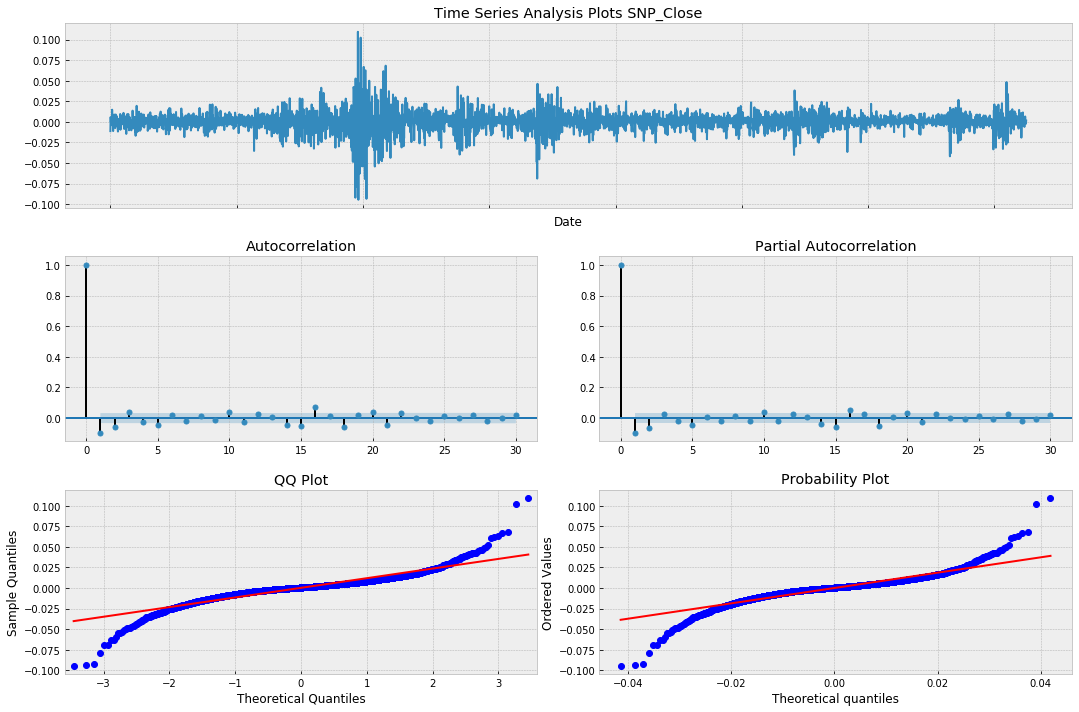

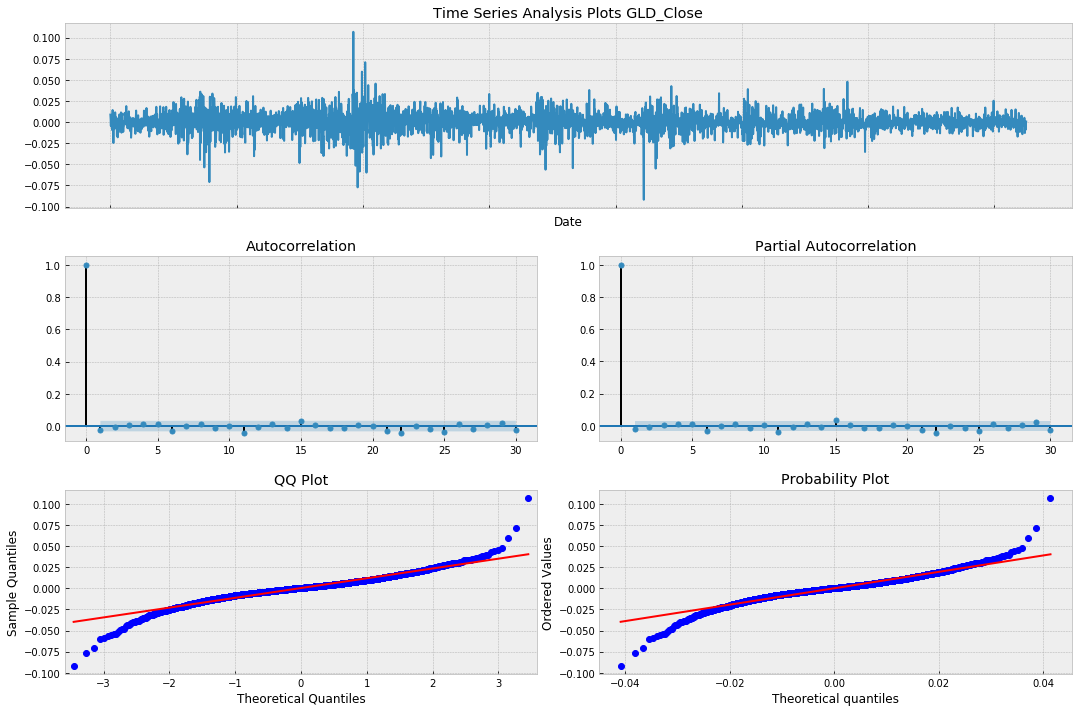

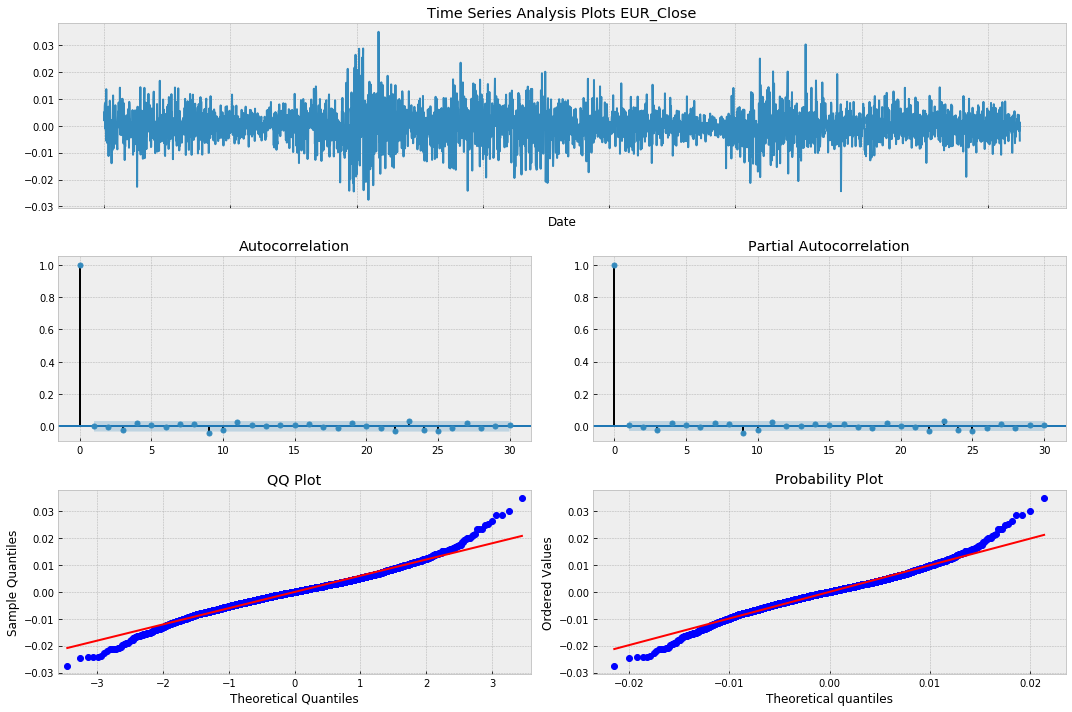

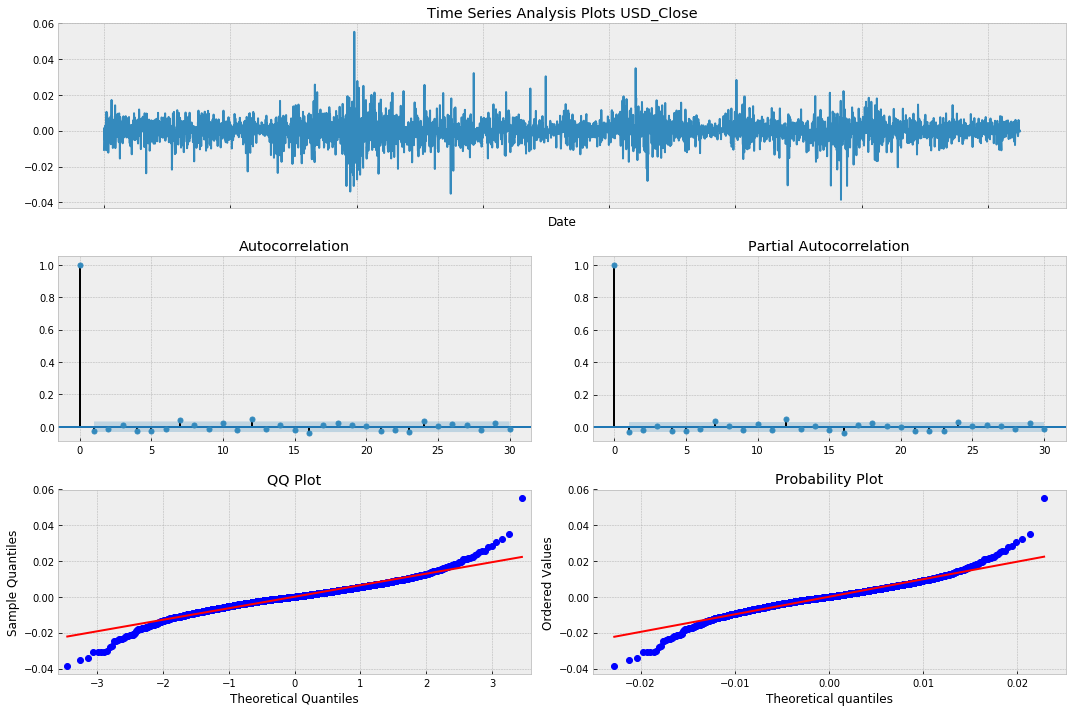

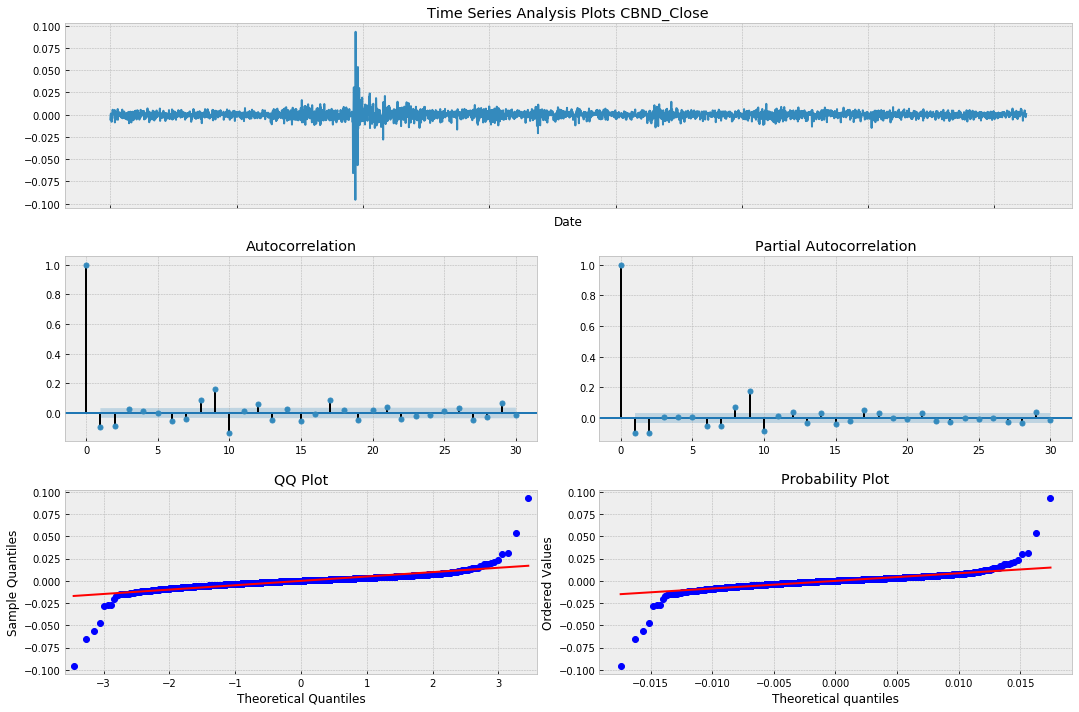

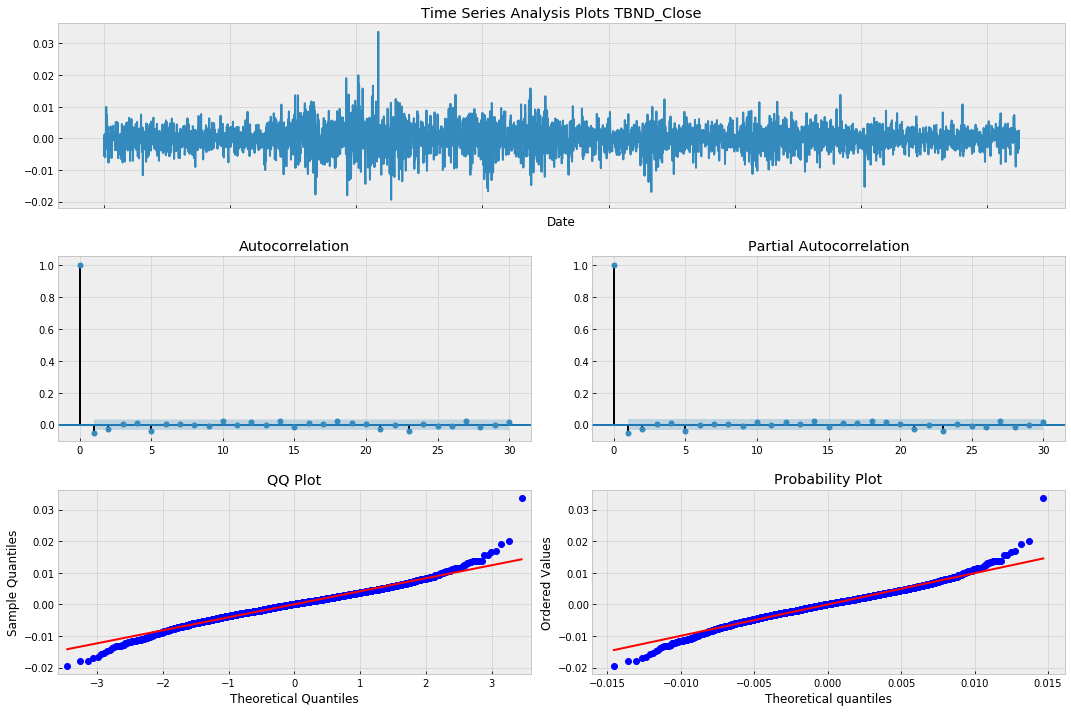

In [4]:
i = 0
for column in data:
    if i % 2 == 0:
        tsplot(data[column], lags = 30, name = column)
    i+=1

# However, while it appears to be normal, in order to do proper time series analysis
I must ask two questions: Specifically:
 1. Is the data mean stationary?
 2. Is the time series stationary in variance?

By applying an Auto-Regressive Conditional Heteroskedasticity Model or the generalized form which utilizes the Moving Average Component
We can see whether the data is in reality stationary
In any case, what we want to do is first fit the model to an ARIMA
This will require itterating different combinations of the model inputs

p, d, and q, which stand for:

p: number of autoregressive terms

d: number of nonseasonal differences needed for stationarity

q: number of lagged forecast errors

These inputs exist because they are the respective components of the two
Models that make up ARIMA (Auto-Regressive) and (Moving-Averge)
Auto-Regressive(p) models are linear combintions of past observations
Whereas Moving Average models are linear combinations of past error terms

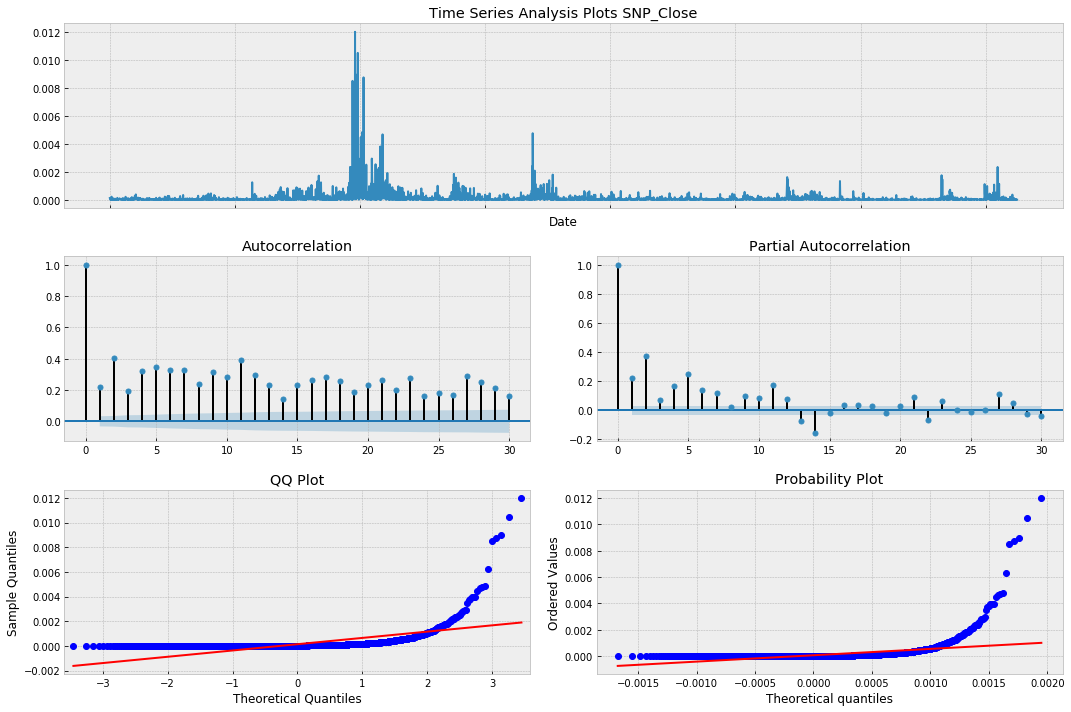

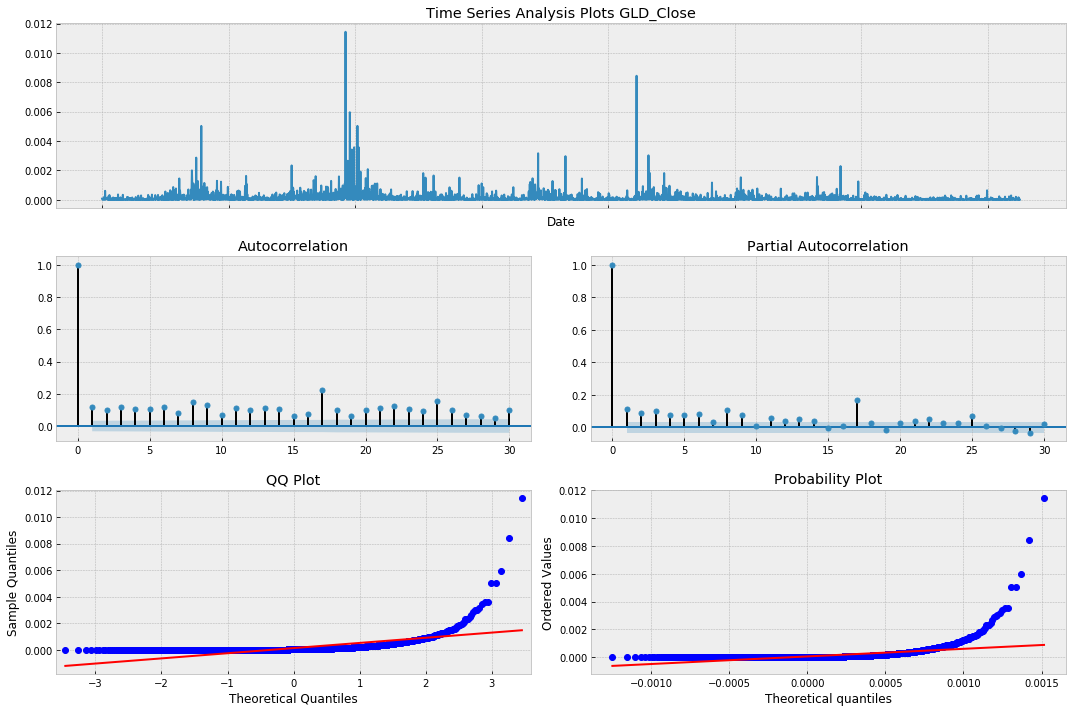

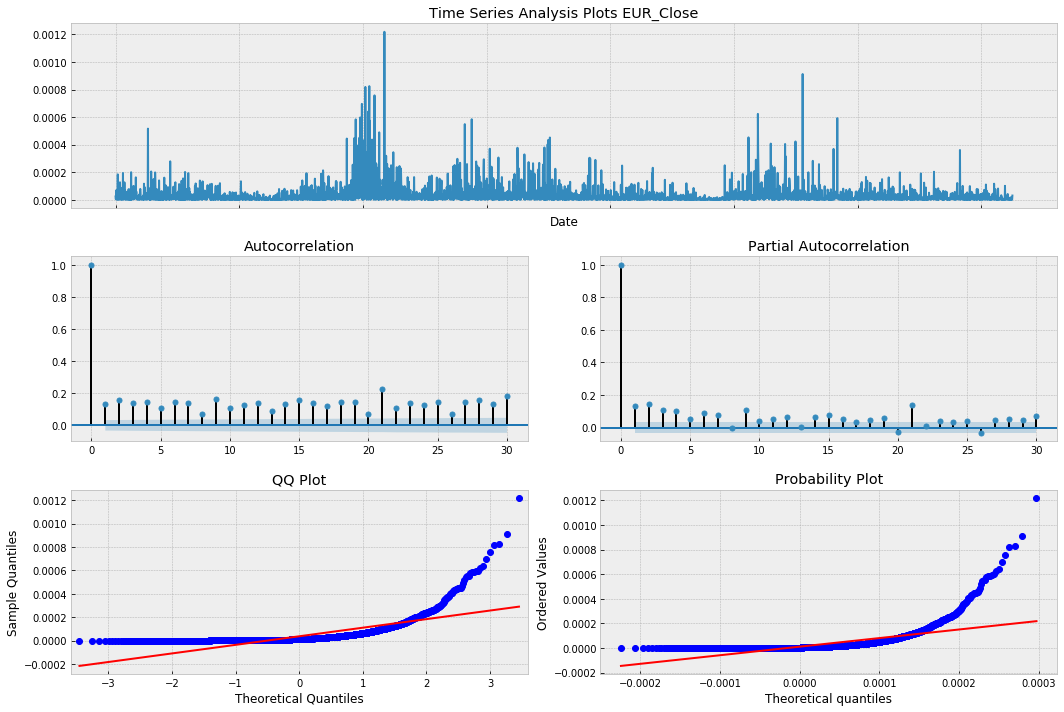

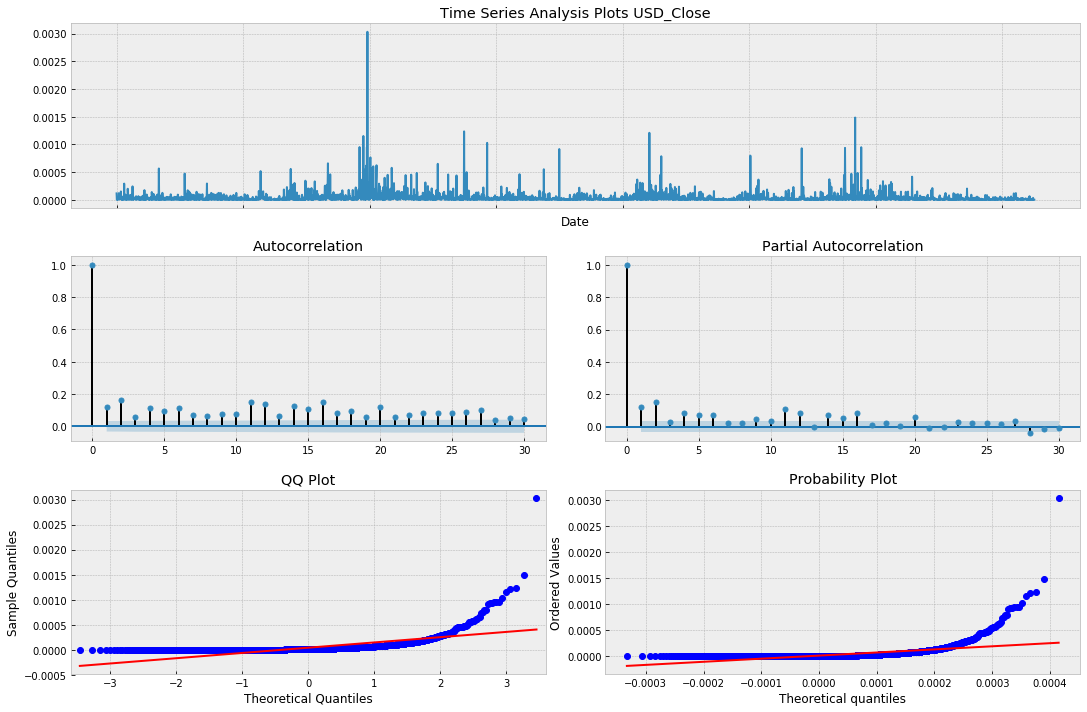

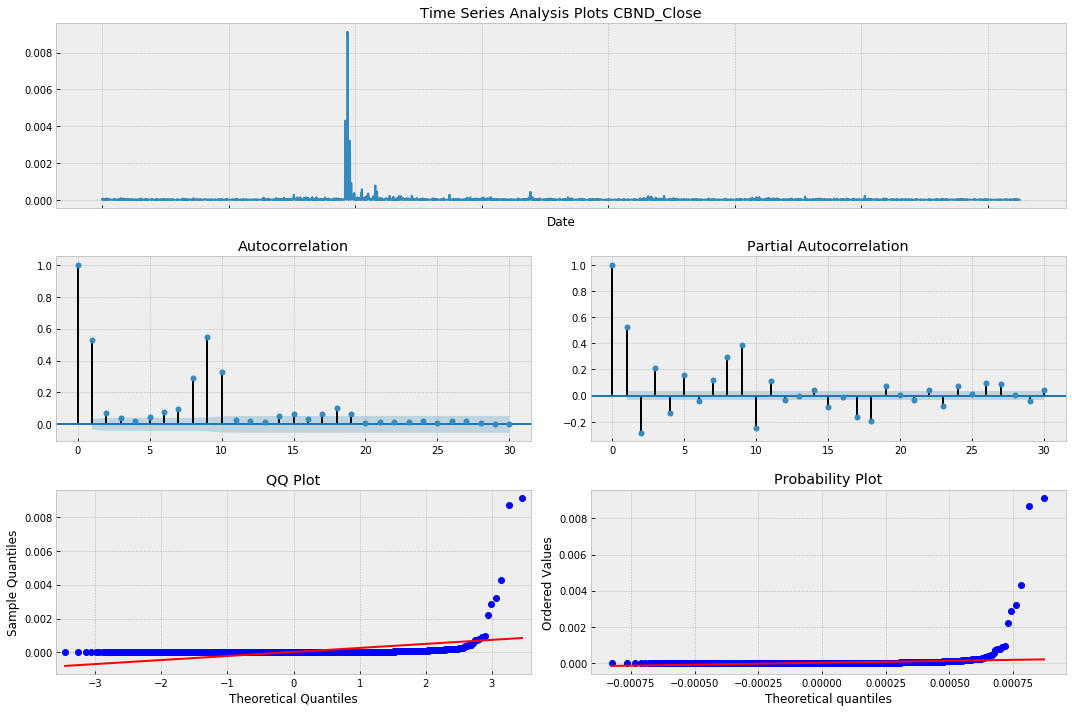

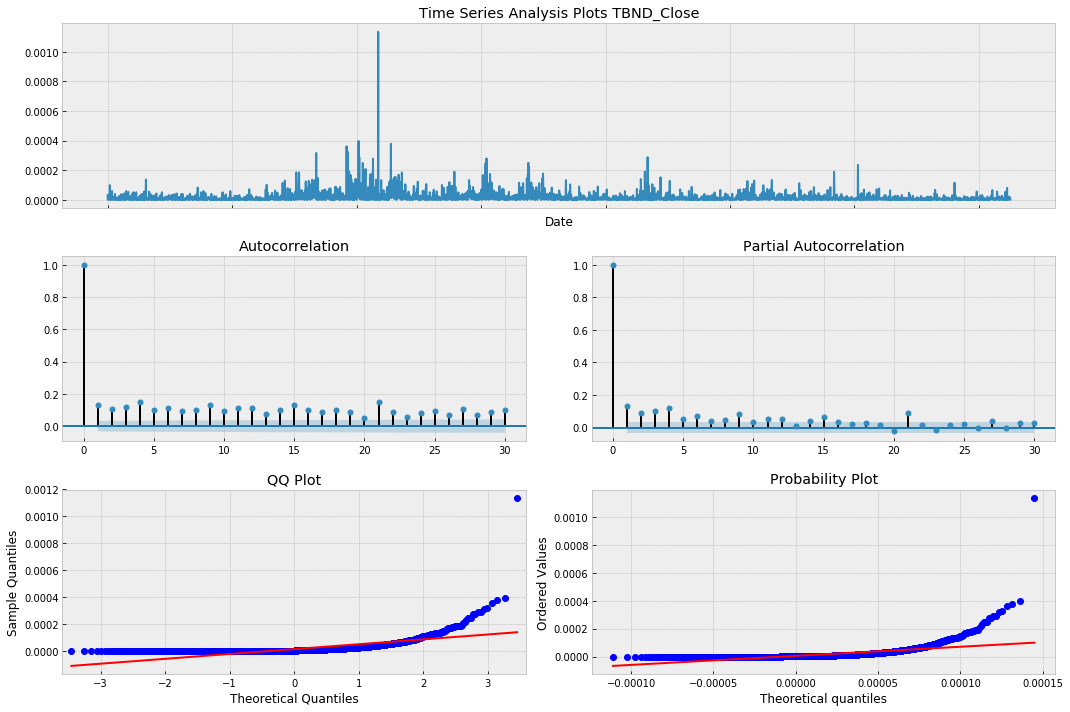

In [5]:
#This will help in identifying the correct ARIMA fits
i = 0
for column in data:
    if i % 2 == 0:
        tsplot(data[column]**2, lags = 30, name = column)
    i+=1

# Section attempts to find ARIMA fits the Hard Way
Proceeding to itterate through combinations of ARIMA(p,d,q) modles.
These will create the baseline for picking the GARCH model orders.
Will be based on ARIMA with lowest AIC: 
What is good about AIC?
Well, it stands for Akaike's Information Criterion (calculated):
AIC = -2(log-likelihood of the model) + 2K.
K is the number of model parameters.
Log-Likelihood is the measure of model fit.
Often can be the Log of the R^2 Parameter for OLS.
AIC = 2k + n Log(RSS/n) where RSS is the difference between the actual, and predicted.

In [ ]:
data.reset_index(inplace = True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)

In [ ]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(6)
    d_rng = range(1)
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [ ]:
i = 0
date_range = pd.date_range(data.index[0], data.index[-1])
result_array = []
for column in data:
    if i % 2 == 0:
        ts = data[column]
        ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
        result_array.append(_get_best_model(ts))
    i+=1

In [ ]:
print(result_array)

The models provide us with the neccesary residuals.

The residuals can tell us a lot about the variance.

Squaring the residuals can show us if our model experiences any areas where the variance from the mean is particularly high and because squaring effectively provides absolutes, we can use the Autocorrelation and Partial Autocorrelation functions to show that these models are in fact Heteroskedastic.

In [ ]:
data_headers = list(data)
i = 1
model_dict = {}
model_order = {}
header_ind = 0
for mod in result_array:
    model_dict[data_headers[header_ind]] = mod[2]
    model_order[data_headers[header_ind]] = mod[1]
    header_ind += 2

In [ ]:
for key in model_dict.keys():
    tsplot(model_dict[key].resid**2, lags = 30, name = key)

In [ ]:
#Fitting GARCH Models with Student T Distribution
garch_models = {}
for key in model_dict.keys():
    p_ = model_order[key][0]
    o_ = model_order[key][1]
    q_ = model_order[key][2]
    garch = arch_model(model_dict[key].resid,p=p_,o=o_,q=q_, dist= 'normal')
    res = garch.fit(update_freq = 500, disp = 'off')
    print(key)
    print(res.summary())
    garch_models[key] = res

In [ ]:
#As each residual component is the result of the model
#The residual can give us 

In [ ]:
#The final thing to do today before I leave: 
#Choose the model orders based on the partial correlation and autocorrelation
#Graphs generated earlier - then build the GARCH Models off of that 
#so manually fit

# Providing ARIMA analysis via the auto- and partial auto-correlation function

Independently running as these are taxing calculations and prone to failure

In [6]:
#Arima Inputs
arima_input = {"SNP_Close":(14,1,5),"GLD_Close":(12,1,4),"EUR_Close":(12,1,5),
               "USD_Close":(12,1,5),"CBND_Close":(5,0,2),"TBND_Close":(4,1,2)}

In [10]:
results_dict = {}
data.reset_index(inplace = True)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace = True)
date_range = pd.date_range(data.index[0], data.index[-1])

In [11]:
name = "SNP_Close"
ts = data[name]
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=arima_input[name] ).fit(method='mle', trend='nc')


In [12]:
name = "GLD_Close"
ts = data[name]
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=arima_input[name] ).fit(method='mle', trend='nc')

In [13]:
name = "EUR_Close"
ts = data[name]
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=arima_input[name] ).fit(method='mle', trend='nc')

In [14]:
name = "USD_Close"
ts = data[name]
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=arima_input[name] ).fit(method='mle', trend='nc')

In [15]:
name = "CBND_Close"
ts = data[name]
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=arima_input[name] ).fit(method='mle', trend='nc')

In [16]:
name = "TBND_Close"
ts = data[name]
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=arima_input[name] ).fit(method='mle', trend='nc')

In [17]:
#Same Process for GARCH
garch_models = {}

# Section for GARCH Models

In [18]:
name = "SNP_Close"
p_ = arima_input[name][0]
o_ = arima_input[name][1]
q_ = arima_input[name][2]
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

SNP_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [19]:
name = "GLD_Close"
p_ = arima_input[name][0]
o_ = arima_input[name][1]
q_ = arima_input[name][2]
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

GLD_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [20]:
name = "EUR_Close"
p_ = arima_input[name][0]
o_ = arima_input[name][1]
q_ = arima_input[name][2]
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

EUR_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [21]:
name = "USD_Close"
p_ = arima_input[name][0]
o_ = arima_input[name][1]
q_ = arima_input[name][2]
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

USD_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [22]:
name = "CBND_Close"
p_ = arima_input[name][0]
o_ = arima_input[name][1]
q_ = arima_input[name][2]
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

CBND_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [23]:
name = "TBND_Close"
p_ = arima_input[name][0]
o_ = arima_input[name][1]
q_ = arima_input[name][2]
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

TBND_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


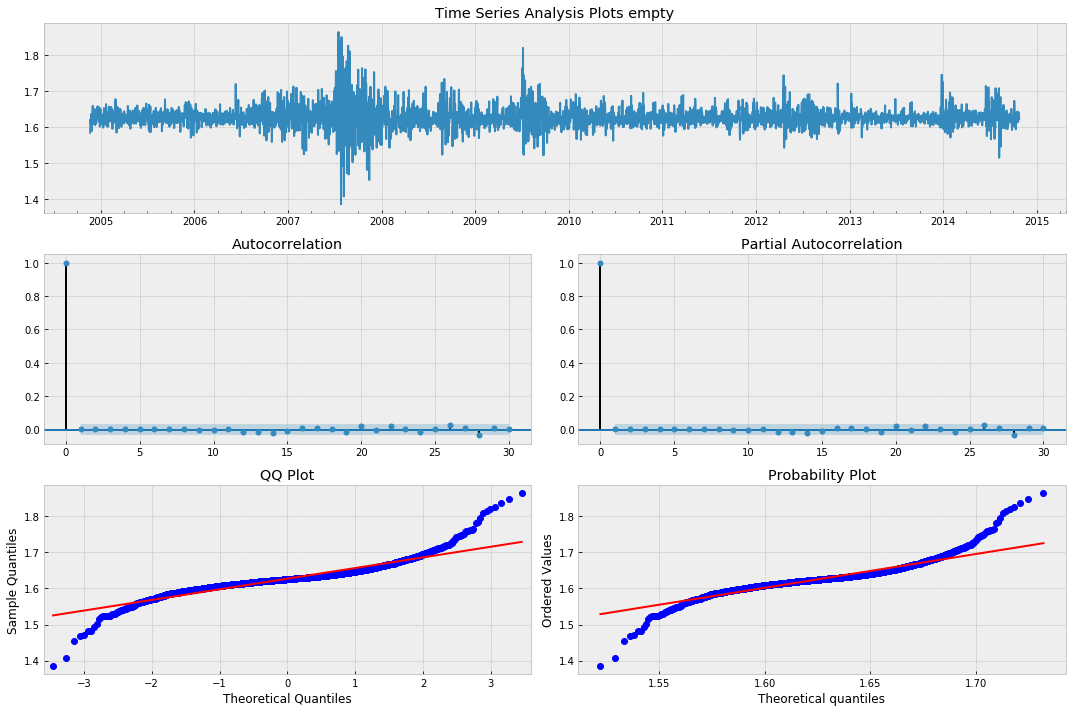

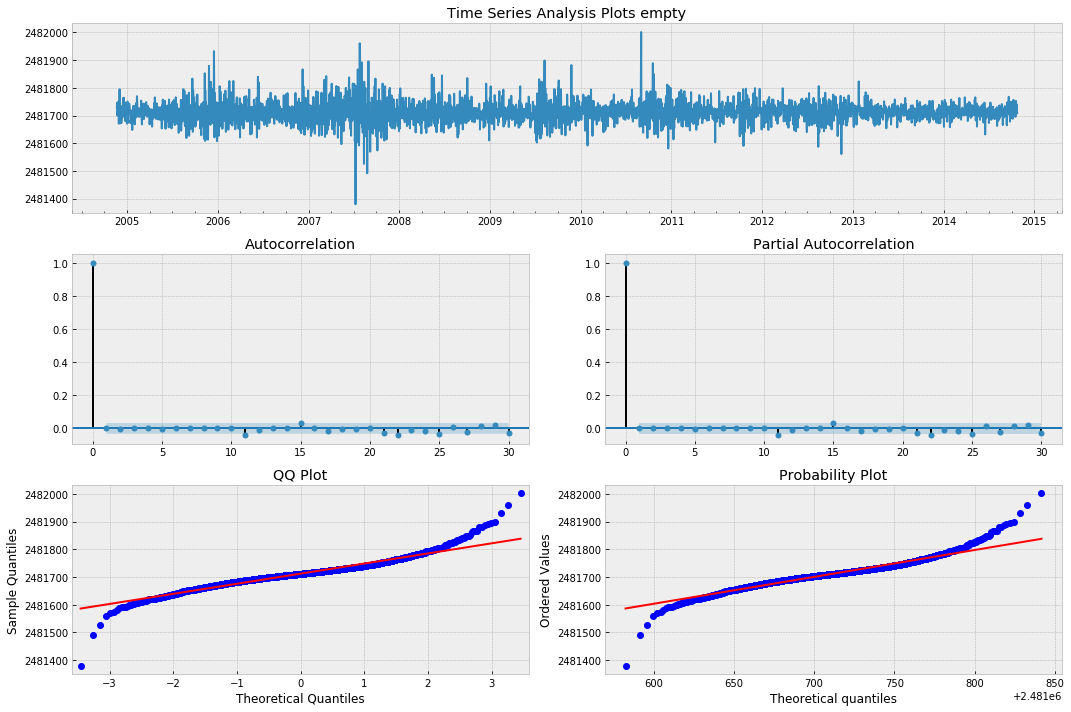

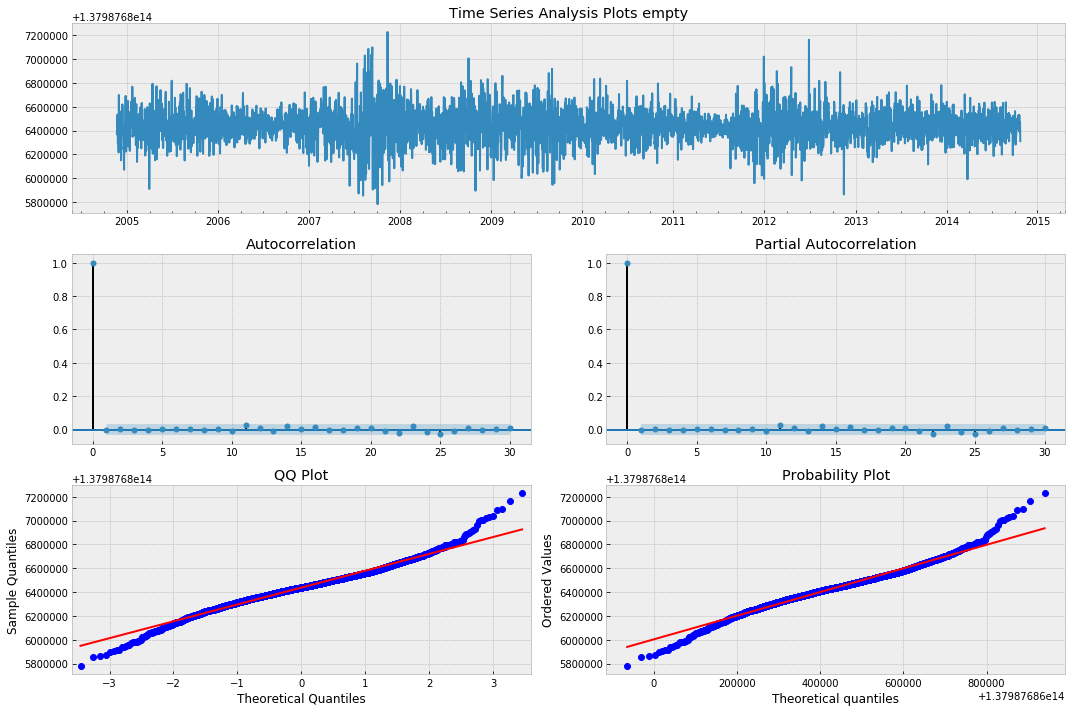

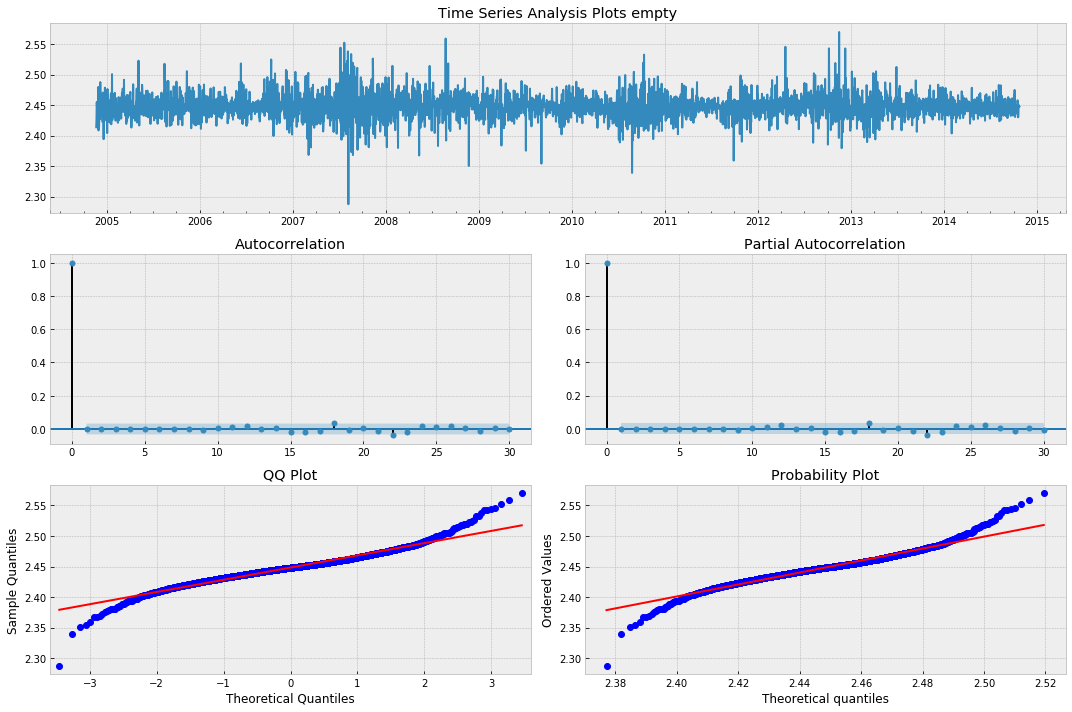

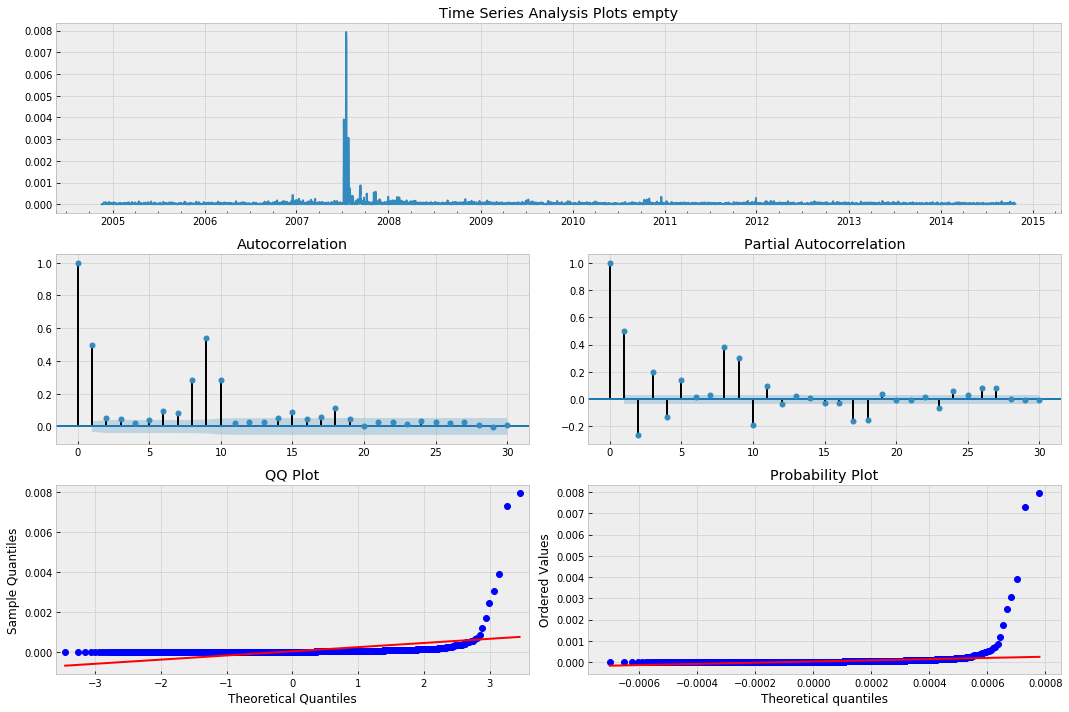

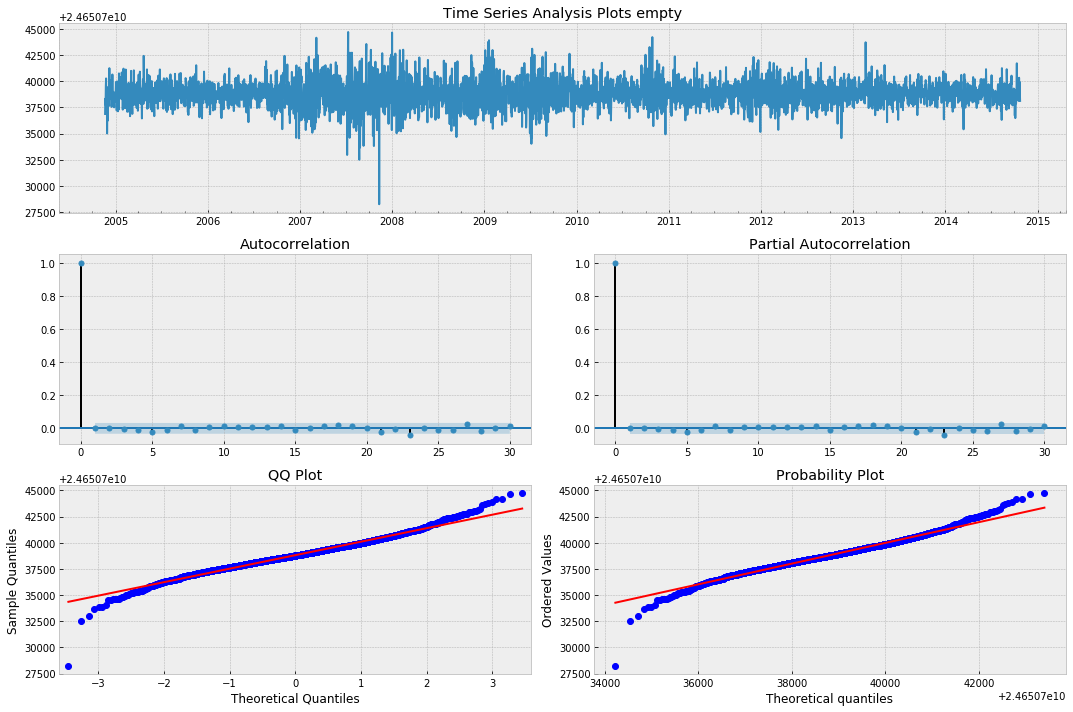

In [24]:
#Testing if autocorrelation still a problem
for key in garch_models.keys():
    tsplot(garch_models[key].resid**2, lags = 30)

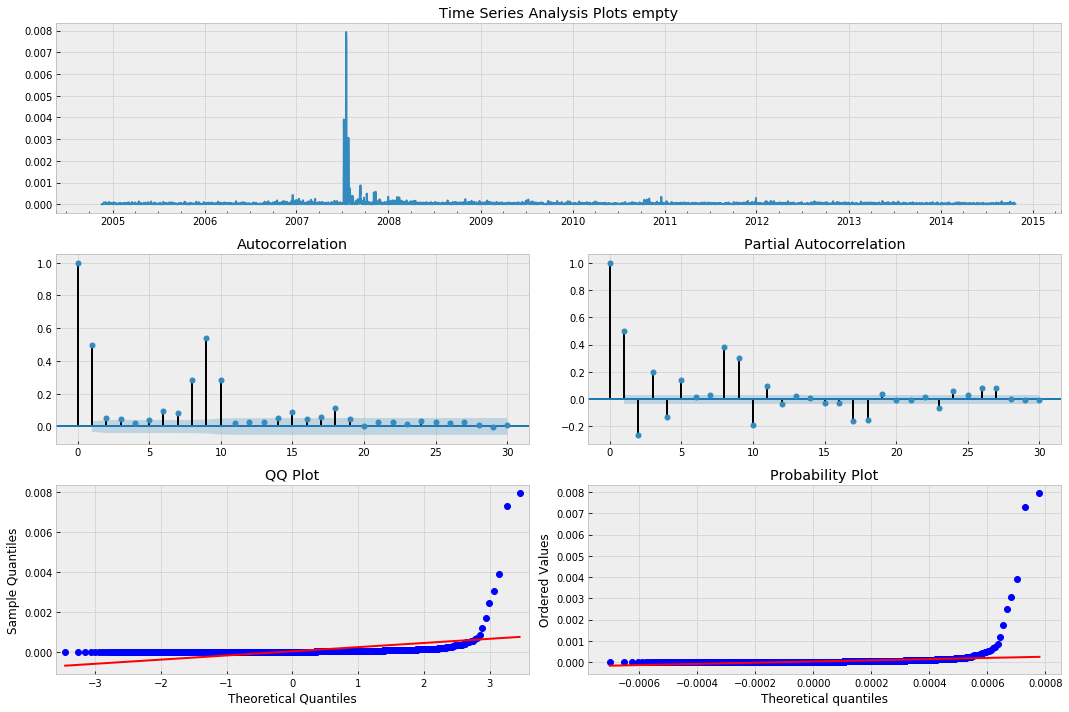

In [25]:
#The corporate bond market suffered too large a shok in 2007-2008 and it
#shows that we cannot work with this outlier (our models will be better)
#Without this date range
tsplot(garch_models["CBND_Close"].resid**2, lags = 30)

In [26]:
#Final Steps: Outputting the residuals from each model into a dataframe
#Saving that dataframe as a csv to be imported in other data
#These are residuals from ARIMA models
residual_df = pd.DataFrame()
for key in results_dict.keys():
    arr = results_dict[key].resid
    residual_df[key] = arr

In [65]:
#Return original index:
residual_df.set_index(data.index[:-1], inplace = True)

In [66]:
#Important - It is missing the last row (as a result of the time series transformation)
residual_df.to_csv("ResidualARIMAData.csv")

# Taking the results from Garch and outputing forecasted Variance

(3626, 0)
(3626, 1)
(3626, 1)
(3626, 1)
(3626, 1)
(3626, 1)


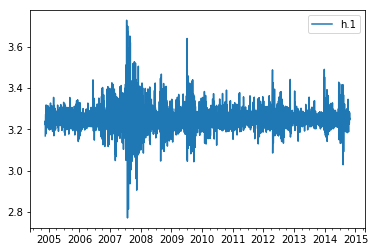

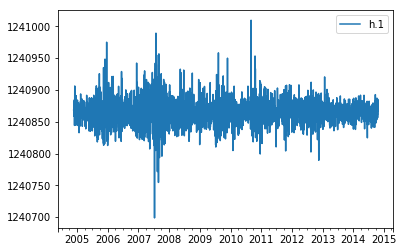

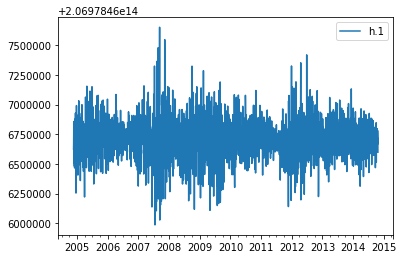

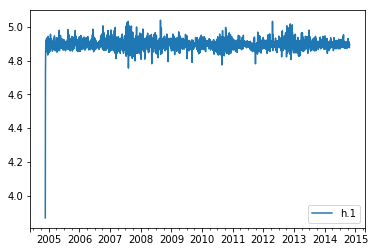

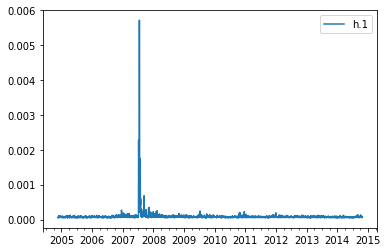

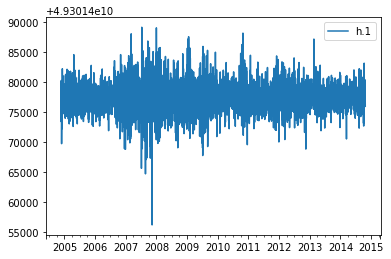

In [30]:
forecast_df = pd.DataFrame(ts.index[1:])
forecast_df.set_index(0, inplace = True)
print(forecast_df.shape)
for column in garch_models.keys():
    if column == "CBND_Close":
        fore = garch_models[column].forecast(start = pd.to_datetime(2004-11-20))
        forecast_df[column] = fore.variance.values.reshape((fore.variance.values.shape[0],))[1:]
    else:
        fore = garch_models[column].forecast(start = pd.to_datetime(2004-11-20))
        fore.variance.plot()
        forecast_df[column] = fore.variance.values.reshape((fore.variance.values.shape[0],))


In [31]:
#Then, normalize the data (and output it into a csv)
#That's it after
forecast_df.index.names = ['Date']

In [32]:
#I am assuming that the GARCH model, in the way that it predicts, started off the
#USD_CLose prediction too high (feed forward)
#Therefore I will drop the first 4 rows and normalize
from sklearn import preprocessing
norm_forecast = pd.DataFrame()
for column in forecast_df:
    norm_forecast[column] = preprocessing.scale(forecast_df[column].values[4:])

C:\Users\alexk\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
C:\Users\alexk\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:176: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [33]:
norm_forecast.set_index(data.index[4:-1], inplace = True)

In [72]:
norm_forecast.to_csv('Norm_Garch_forecast.csv')

# Last Part, Pulling Values from ARIMA Fitted Valules

Figure(432x288)
Figure(432x288)
Figure(432x288)
Figure(432x288)
Figure(432x288)
Figure(432x288)


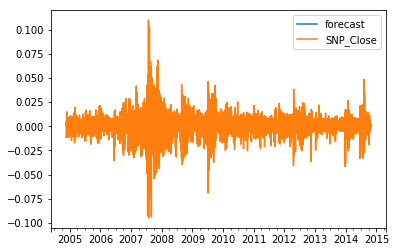

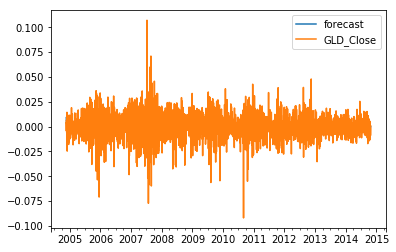

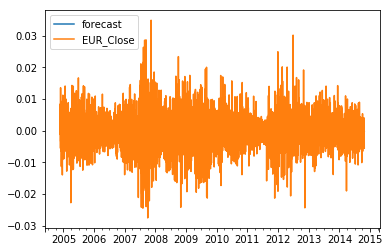

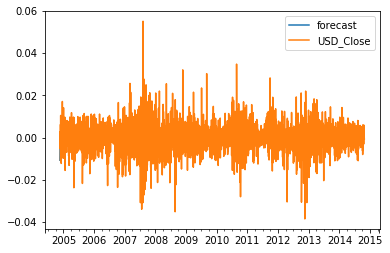

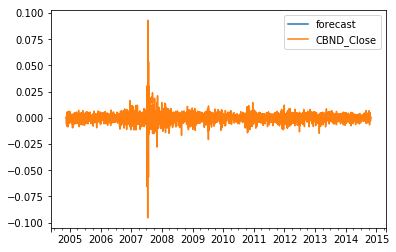

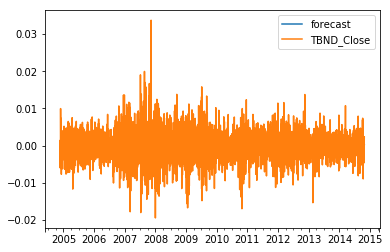

In [47]:
for key in results_dict.keys():
    print(results_dict[key].plot_predict())

In [54]:
arima_predict = pd.DataFrame()
for key in results_dict.keys():
    arima_predict[key] = results_dict[key].predict()[1:]

,SNP_Close,GLD_Close,EUR_Close,USD_Close,CBND_Close,TBND_Close
2004-11-21,-0.008864,0.002636,0.001454,-0.005611,0.000546,-0.003178
2004-11-22,-0.002398,0.007425,0.000245,-0.004739,-0.000135,-0.001074
2004-11-23,-0.004323,-0.002958,-0.002903,0.001937,-0.000429,-0.002659
2004-11-24,-0.000714,-0.001351,-0.003339,-0.000941,0.000192,0.002252
2004-11-25,0.002832,0.001112,0.005102,-0.005227,0.001451,0.003934
2004-11-26,0.003601,0.008691,0.003603,-0.004131,0.000714,-0.001001
2004-11-27,-0.015671,-0.002645,-0.000927,0.002866,-0.000232,0.001052
2004-11-28,0.001183,0.010886,0.008051,-0.007198,-0.000083,0.000082
2004-11-29,0.000221,-0.012139,-0.009787,0.008621,-0.000260,-0.011643
2004-11-30,0.001860,0.011263,0.006817,-0.011273,-0.000319,-0.003111


In [68]:
arima_predict.set_index(data.index[1:-1], inplace = True)

In [71]:
arima_predict.to_csv("ARIMA_Predicted_Values.csv")

# Generating ARIMA and GARCH Models for Bitcoin

In [73]:
#Importing BTC returns
btc = pd.read_csv("BTC_Final.csv")
btc.set_index('Date',inplace = True)
column = ['BTC_Volume']
btc.drop(column, inplace = True, axis = 1)
print(btc.shape)
btc.head()

(3200, 1)


,BTC_Close
Date,
2010-07-17,0.550310
2010-07-18,-0.060508
2010-07-19,-0.077962
2010-07-20,0.058087
2010-07-21,-0.450129


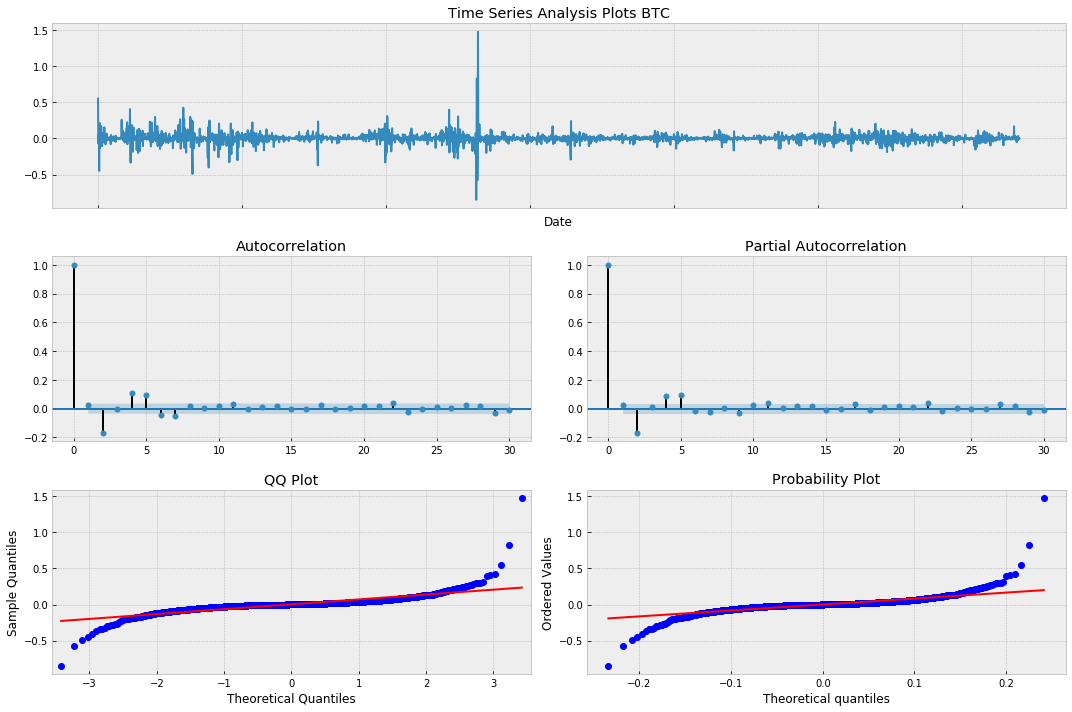

In [74]:
tsplot(btc['BTC_Close'], lags = 30, name = 'BTC')

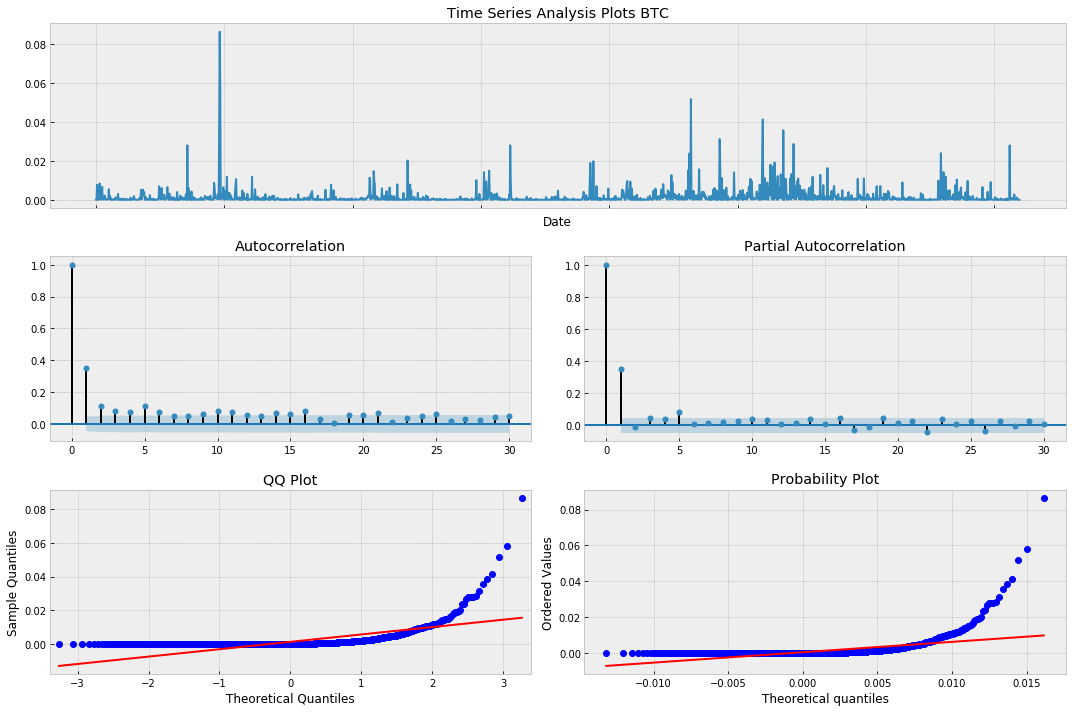

In [84]:
#Does display some tendencies for autocorrelation (also extreme returns)
#I will look at it over the past
tsplot(btc['BTC_Close'][1400:]**2, lags = 30, name = 'BTC')

In [85]:
#I want to look at it after that enormous spike and volatility
#The Asset is fairly different over time
#Let's take the last couple thousand entries (since 2014)
#And run the model on those (displays much more interpretable features)
#For an Arima Fit (i.e. Partial) Looks like an ARIMA(1,0,2)

In [96]:
btc_set = pd.DataFrame(btc['BTC_Close'][1400:])
btc_set.head()

,BTC_Close
Date,
2014-05-17,-0.005870
2014-05-18,-0.013959
2014-05-19,0.087663
2014-05-20,0.008773
2014-05-21,0.052830


In [97]:
btc_set.reset_index(inplace = True)
btc_set['Date'] = pd.to_datetime(btc_set['Date'])
btc_set.set_index('Date', inplace = True)
date_range = pd.date_range(btc_set.index[0], btc_set.index[-1])

In [100]:
#Running ARIMA fit
name = "BTC_Close"
ts = btc_set['BTC_Close']
ts.index = pd.DatetimeIndex(date_range[:ts.shape[0]], freq = ts.index.inferred_freq)
results_dict[name] = smt.ARIMA(ts, order=(2,0,1)).fit(method='mle', trend='nc')


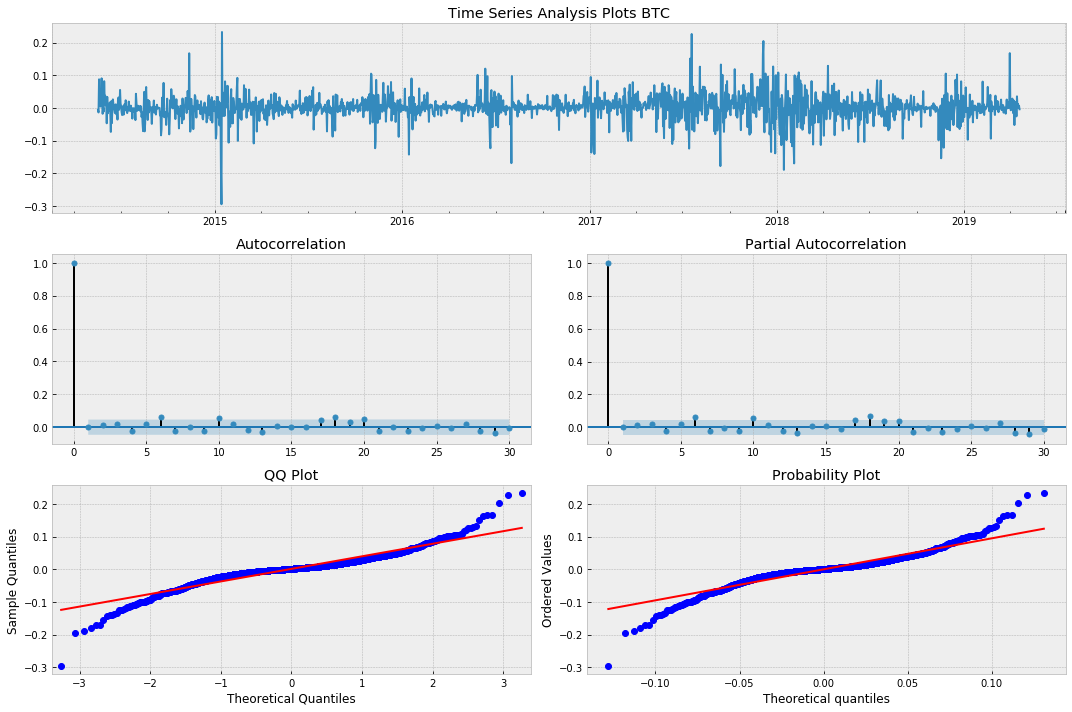

In [105]:
tsplot(results_dict['BTC_Close'].resid, lags = 30, name = 'BTC')

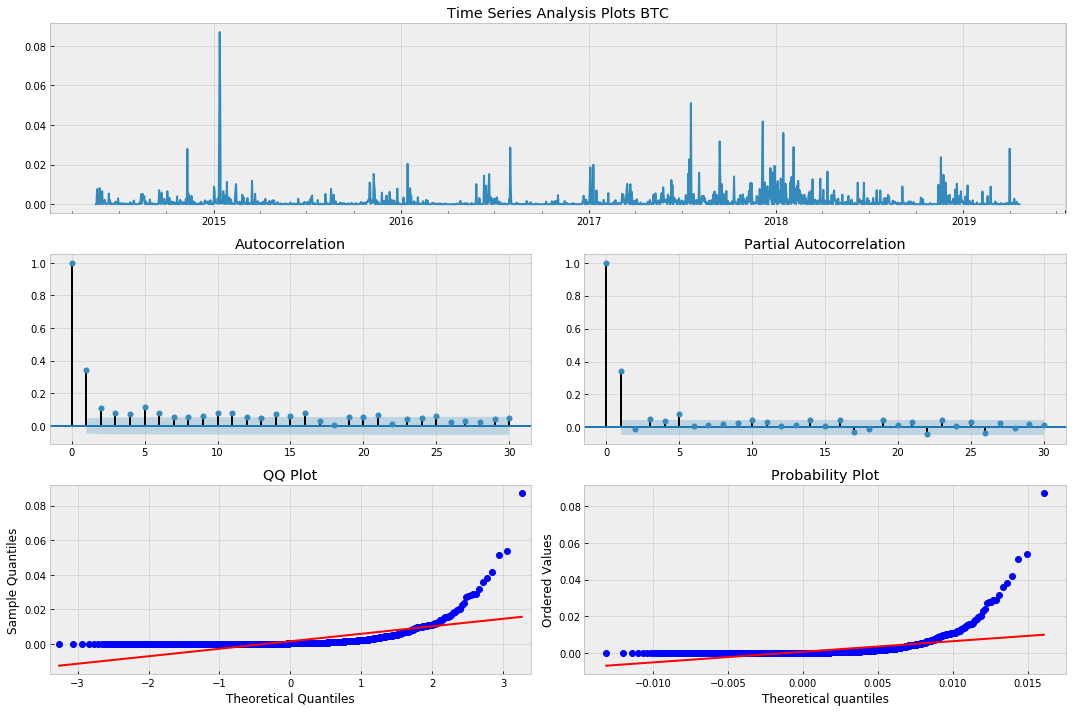

In [104]:
tsplot(results_dict['BTC_Close'].resid**2, lags = 30, name = 'BTC')

In [106]:
name = "BTC_Close"
p_ = 2
o_ = 0
q_ = 1
garch = arch_model(results_dict[name].resid,p=p_,o=o_,q=q_, dist= 'StudentsT')
res = garch.fit(update_freq = 500, disp = 'off')
print(name)
garch_models[name] = res

BTC_Close


C:\Users\alexk\Anaconda3\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


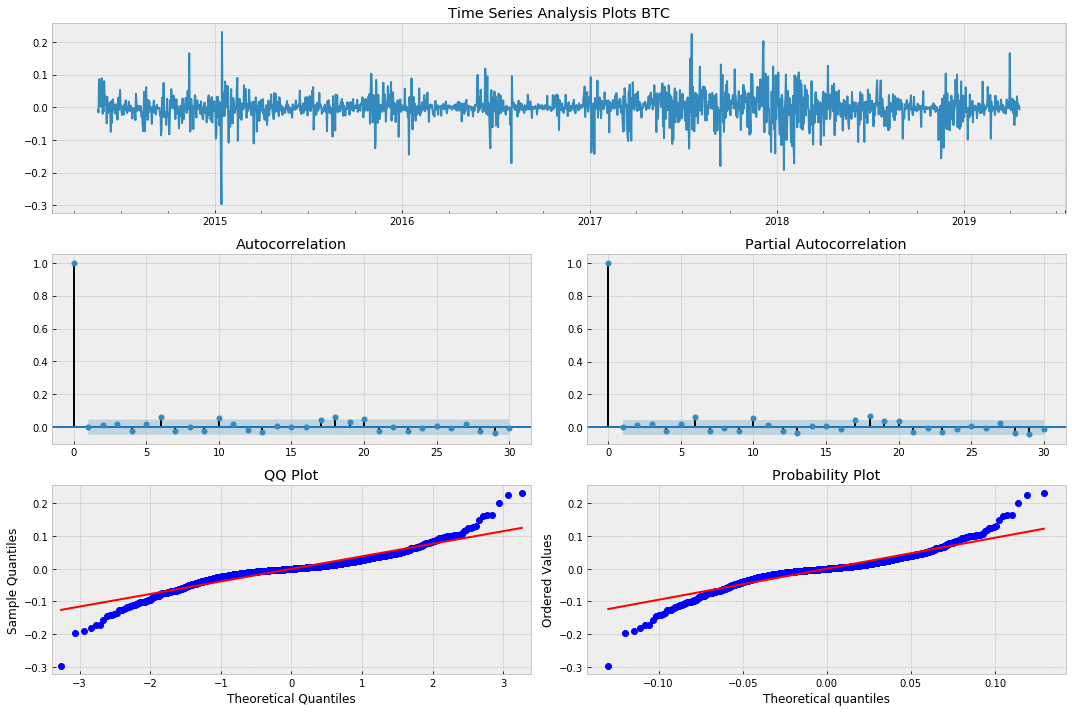

In [108]:
tsplot(garch_models['BTC_Close'].resid, lags = 30, name = 'BTC')

In [122]:
btc_arima_residuals = pd.DataFrame(results_dict['BTC_Close'].resid, columns = ['BTC_Res'])
btc_arima_residuals.set_index(btc_set.index, inplace = True)

In [124]:
btc_arima_residuals.to_csv("BTC_Arima_Residuals.csv")